In [2]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def G_f1_score(label_map: dict, y_true, y_pred):
    '''
    Genuine-priority F1-score
    The real class (0) have the weight is 0.5, the other class have the weight is 0.5/(num_classes-1)
    However, the fake class with 0 samples in the dataset, so we don't need to consider it
    '''
    # calculate F1-score for each class
    f1_scores = []
    n_fake_classes = len(label_map) - 1
    for k, v in label_map.items():
        if k not in y_true:
            n_fake_classes -= 1
            continue
        tp = np.sum((y_true == k) & (y_pred == k))
        fp = np.sum((y_true != k) & (y_pred == k))
        fn = np.sum((y_true == k) & (y_pred != k))
        f1 = 2*tp / (2*tp + fp + fn)
        f1_scores.append(f1)
    
    # calculate weighted F1-score           
    weight = 0.5 / n_fake_classes
    G_f1 = 0.5 * f1_scores[0] + 0.5 / n_fake_classes * (np.sum(f1_scores[1:]))
    
    return G_f1

def micro_f1_score(label_map:dict, y_true, y_pred):
    '''
    Micro F1-score
    Calculate the TP, FP, FN for each class,
    Sum all TP, FP, FN of all classes, then calculate the F1-score
    '''
    TP, FP, FN = 0, 0, 0
    for k, v in label_map.items():
        TP += np.sum((y_true == k) & (y_pred == k))
        FP += np.sum((y_true != k) & (y_pred == k))
        FN += np.sum((y_true == k) & (y_pred != k))
    micro_f1 = 2*TP / (2*TP + FP + FN)
    
    return micro_f1

def macro_f1_score(label_map:dict, y_true, y_pred):
    '''
    Macro F1-score
    Calculate the F1-score for each class, then average them
    '''
    f1_scores = []
    for k, v in label_map.items():
        if k not in y_true:
            continue
        tp = np.sum((y_true == k) & (y_pred == k))
        fp = np.sum((y_true != k) & (y_pred == k))
        fn = np.sum((y_true == k) & (y_pred != k))
        f1 = 2*tp / (2*tp + fp + fn)
        f1_scores.append(f1)
    macro_f1 = np.mean(f1_scores)
    
    return macro_f1


# baseline

## vocoder

In [24]:
# label_map = {'Real': 0, 'encodec': 1, 'f-melgan': 2, 'hifigan': 3, 'm-melgan': 5, 'univnet': 6}
# map_label = {v: k for k, v in label_map.items()}
# index_map is reverse of label_map
res_df = pd.read_csv('/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/scores_eval.txt', sep=' ', header=None)
res_df.columns = ['label', 'utt', 'pred']
res_df = res_df[res_df['utt'].str.contains('original')]
res_df = res_df[res_df['label'] < 7]
res_df['label'] = res_df['label'].map(map_label)
res_df['pred'] = res_df['pred'].map(map_label)
print(res_df.shape)
# calculate ACC, F1-score
y_true = res_df['label'].values
y_pred = res_df['pred'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)

# visualize confusion matrix
# display the percenntage of each class in the confusion matrix
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

plt.figure(figsize=(10, 10))
cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=label_map.keys())
disp.plot(cmap='Greens', values_format='.2f')
# Change label font size
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# Rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('figs/baseline_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()




ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements

In [139]:

mlaad_df = pd.read_csv('../traindata/mlaad_v5/meta_ST.csv')
mlaad_df['utt'] = mlaad_df['path'].apply(lambda x: x.split('/')[-1].split('.')[0])
res_df[res_df['label']=='encodec']

,label,utt,pred
2990,encodec,original_wives_and_daughters_11,univnet
2995,encodec,original_jane_eyre_24,Real
3000,encodec,original_northandsouth_14,univnet
3005,encodec,original_poisoned_pen_10,hifigan
3010,encodec,original_dorothy_and_wizard_oz_02,univnet
...,...,...,...
152725,encodec,original_northandsouth_50,hifigan
152730,encodec,original_wives_and_daughters_32,Real
152735,encodec,original_jane_eyre_24,Real
152740,encodec,original_northandsouth_34,univnet


In [149]:
print(mlaad_df[(mlaad_df['utt'].str.contains('wives_and_daughters_11')) & (mlaad_df['vocoder']=='encodec')].shape)
print(res_df[(res_df['utt'].str.contains('wives_and_daughters_11')) & (res_df['label']=='encodec')].shape)

(59, 16)
(44, 3)


# ours

In [3]:
mlaad_df = pd.read_csv('../traindata/mlaad_v5/meta_ST.csv')
mlaad_df

,path,duration,training_data,model_name,architecture,subset,Speaker name,Age,Gender,Language,label,acoustic,vocoder,e2e,vocoder2
0,fake/pt/tts_models_multilingual_multi-dataset_...,2.376,multi-dataset,tts_models/multilingual/multi-dataset/xtts_v2,xtts_v2,eval,-,-,-,pt,spoof,xtts_v2,hifigan,True,xtts_v2
1,fake/pt/tts_models_multilingual_multi-dataset_...,2.808,multi-dataset,tts_models/multilingual/multi-dataset/xtts_v2,xtts_v2,eval,-,-,-,pt,spoof,xtts_v2,hifigan,True,xtts_v2
2,fake/pt/tts_models_multilingual_multi-dataset_...,2.376,multi-dataset,tts_models/multilingual/multi-dataset/xtts_v2,xtts_v2,eval,-,-,-,pt,spoof,xtts_v2,hifigan,True,xtts_v2
3,fake/pt/tts_models_multilingual_multi-dataset_...,2.808,multi-dataset,tts_models/multilingual/multi-dataset/xtts_v2,xtts_v2,eval,-,-,-,pt,spoof,xtts_v2,hifigan,True,xtts_v2
4,fake/pt/tts_models_multilingual_multi-dataset_...,2.700,multi-dataset,tts_models/multilingual/multi-dataset/xtts_v2,xtts_v2,eval,-,-,-,pt,spoof,xtts_v2,hifigan,True,xtts_v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102920,CommonVoice/de/common_voice_de_21149754.wav,7.104,-,-,-,eval,1461034d98b09a1806d68725115ca7ede20db8859586d8...,Adult,Female,de,bonafide,-,-,False,-
102921,CommonVoice/ja/common_voice_ja_36298016.wav,4.032,-,-,-,eval,70a7ca54d4594eb37bdb0d588c900f94e4e174bbd95e2b...,Adult,Female,jp,bonafide,-,-,False,-
102922,CommonVoice/fr/common_voice_fr_20316840.wav,3.408,-,-,-,eval,02058e0159c455fada6f5a9272522f0457446aa2723564...,Teenager,Male,fr,bonafide,-,-,False,-
102923,CommonVoice/zh-CN/common_voice_zh-CN_22528148.wav,5.904,-,-,-,train,291b3efcc8d4b4d1ac214130a72463857304f20d28e9be...,Adult,Female,zh-cn,bonafide,-,-,False,-


In [7]:
# category = 'vocoder'
print("model_name,acoustic,vocoder,#samples")
for cl in mlaad_df['model_name'].unique():
    print(f"{cl},{mlaad_df[mlaad_df['model_name']==cl]['acoustic'].unique()[0]},{mlaad_df[mlaad_df['model_name']==cl]['vocoder'].unique()[0]},{mlaad_df[mlaad_df['model_name']==cl].shape[0]}")

model_name,acoustic,vocoder,#samples
tts_models/multilingual/multi-dataset/xtts_v2,xtts_v2,hifigan,7200
tts_models/pt/cv/vits,vits,hifigan,298
tts_models/multilingual/multi-dataset/bark,bark,bark,9600
tts_models/multilingual/multi-dataset/xtts_v1.1,xtts_v1.1,univnet,6000
facebook/mms-tts-rus,vits,hifigan,296
tts_models/tr/common-voice/glow-tts,glow-tts,hifigan,300
tts_models/bg/cv/vits,vits,hifigan,300
tts_models/fr/css10/vits,vits,hifigan,600
tts_models/fr/mai/tacotron2-DDC,tacotron2,fullband-melgan,598
facebook/mms-tts-fra,vits,hifigan,300
OpenVoiceV2,vits,hifigan,898
tts_models/es/mai/tacotron2-DDC,tacotron2,fullband-melgan,299
tts_models/es/css10/vits,vits,hifigan,300
tts_models/de/thorsten/tacotron2-DCA,tacotron2,fullband-melgan,298
facebook/mms-tts-deu,vits,hifigan,595
tts_models/de/css10/vits-neon,vits,hifigan,600
tts_models/de/thorsten/vits,vits,hifigan,300
tts_models/de/thorsten/tacotron2-DDC,tacotron2,hifigan,600
tts_models/hr/cv/vits,vits,hifigan,300
vixTTS,xtts_v2,hifigan,8

In [50]:
mlaad_df.loc[mlaad_df['model_name']=='Mars5', 'vocoder'] = 'unknown'
mlaad_df.loc[mlaad_df['model_name']=='WhisperSpeech', 'vocoder'] = 'vocos'
mlaad_df.loc[mlaad_df['model_name']=='Metavoice-1B', 'vocoder'] = 'unknown'
mlaad_df.loc[mlaad_df['vocoder']=='encodec', 'vocoder'] = 'bark'
mlaad_df.to_csv('../traindata/mlaad_v5/meta_ST.csv', index=False)

In [ ]:
# mlaad_df[mlaad_df.duplicated(subset=['path'])]['subset'].value_counts()
# # drop duplicates
# mlaad_df = mlaad_df.drop_duplicates(subset=['path'])
# mlaad_df.to_csv('../traindata/mlaad_v5/meta_ST.csv', index=False)

In [41]:
mlaad_df[mlaad_df['subset']=='dev']

,path,duration,training_data,model_name,architecture,subset,Speaker name,Age,Gender,Language,label,acoustic,vocoder,e2e,vocoder2
2994,fake/tr/tts_models_multilingual_multi-dataset_...,14.123,multi-dataset,tts_models/multilingual/multi-dataset/bark,bark,dev,-,-,-,tr,spoof,bark,bark,True,bark
2995,fake/tr/tts_models_multilingual_multi-dataset_...,6.603,multi-dataset,tts_models/multilingual/multi-dataset/bark,bark,dev,-,-,-,tr,spoof,bark,bark,True,bark
2996,fake/tr/tts_models_multilingual_multi-dataset_...,5.577,multi-dataset,tts_models/multilingual/multi-dataset/bark,bark,dev,-,-,-,tr,spoof,bark,bark,True,bark
2997,fake/tr/tts_models_multilingual_multi-dataset_...,13.810,multi-dataset,tts_models/multilingual/multi-dataset/bark,bark,dev,-,-,-,tr,spoof,bark,bark,True,bark
2998,fake/tr/tts_models_multilingual_multi-dataset_...,3.470,multi-dataset,tts_models/multilingual/multi-dataset/bark,bark,dev,-,-,-,tr,spoof,bark,bark,True,bark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102893,CommonVoice/es/common_voice_es_34470328.wav,8.928,-,-,-,dev,d904346ebee14ea359c600dd927fda3c180bd306a0b6c0...,Adult,Female,es,bonafide,-,-,False,-
102904,CommonVoice/ru/common_voice_ru_22704308.wav,6.216,-,-,-,dev,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,Adult,Female,ru,bonafide,-,-,False,-
102908,CommonVoice/de/common_voice_de_22079595.wav,6.384,-,-,-,dev,463dc4d1dd87b625bb38b494094c12454d90a9483d8795...,Adult,Male,de,bonafide,-,-,False,-
102911,CommonVoice/es/common_voice_es_20278777.wav,5.088,-,-,-,dev,f2a49028f83776de7aa6263d6aa0927f5448e27ba4e574...,Adult,Male,es,bonafide,-,-,False,-


In [11]:
mlaad_df[mlaad_df['acoustic']=='vits']['model_name'].value_counts()

OpenVoiceV2                          898
tts_models/en/ljspeech/vits--neon    691
tts_models/it/mai_male/vits          600
tts_models/de/css10/vits-neon        600
tts_models/it/mai_female/vits        600
tts_models/fr/css10/vits             600
tts_models/lt/cv/vits                599
MeloTTS                              598
facebook/mms-tts-deu                 595
facebook/mms-tts-eng                 300
tts_models/bg/cv/vits                300
tts_models/ro/cv/vits                300
tts_models/hu/css10/vits             300
tts_models/pl/mai_female/vits        300
tts_models/lv/cv/vits                300
facebook/mms-tts-fin                 300
tts_models/fi/css10/vits             300
tts_models/el/cv/vits                300
facebook/mms-tts-nld                 300
tts_models/de/thorsten/vits          300
tts_models/en/jenny/jenny            300
facebook/mms-tts-fra                 300
tts_models/et/cv/vits                300
tts_models/cs/cv/vits                300
tts_models/es/cs

In [185]:
mlaad_df[(mlaad_df['subset']=='eval')&(mlaad_df['path'].str.contains('common_voice_de_32450528'))]

,path,duration,training_data,model_name,architecture,subset,Speaker name,Age,Gender,Language,label,acoustic,vocoder,e2e,vocoder2
67480,CommonVoice/de/common_voice_de_32450528.wav,5.94,-,-,-,eval,45b088328f6f2b705afaecd33334e3be644c18fd29d51f...,Adult,Female,de,bonafide,-,-,False,-


# Acoustic

In [8]:
# label_map = {'-': 0,'xtts_v2': 1, 'vits': 2, 'tacotron2': 3, 'xtts_v1.1': 4, 'Metavoice': 5, 'Mars5': 6, 'speedy-speech': 7, 'fast_pitch': 8, 'bark': 9}

seen_classes = mlaad_df[mlaad_df['subset']=='train']['acoustic'].unique()
seen_classes = np.sort(seen_classes)
label_map = {seen_classes[i]: i for i in range(len(seen_classes))}
print(label_map)
t = len(label_map)
classes = mlaad_df['acoustic'].unique()
for c in classes:
    if c not in label_map:
        label_map[c] = t
        t += 1
print(label_map)
# map_label is reverse of label_map
map_label = {v: k for k, v in label_map.items()}
print(map_label)
# acoustic_df is the dataframe that only path and acoustic column from mlaad_df
acoustic_df = mlaad_df.copy()[['path', 'acoustic', 'subset']]
# acoustic_df['label'] = mlaad_df['acoustic'].map(label_map)
# fill NA with -1
# acoustic_df = acoustic_df.fillna(-1)
# set the label column type to int
# acoustic_df['label'] = acoustic_df['label'].astype(int)
acoustic_df=acoustic_df[acoustic_df['subset']=='eval']
# acoustic_df = acoustic_df[acoustic_df['label']!=-1]

# label_map match to the label of the acoustic_df
# label_idx = acoustic_df['label'].unique()
# get keys of label_map that exist in label_idx
# map_label = {k: v for k, v in label_map.items() if v in label_idx}

{'-': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 'tacotron2': 6, 'vits': 7, 'xtts_v1.1': 8, 'xtts_v2': 9}
{'-': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 'tacotron2': 6, 'vits': 7, 'xtts_v1.1': 8, 'xtts_v2': 9, 'glow-tts': 10, 'overflow': 11, 'WhisperSpeech': 12, 'parler': 13, 'tortoise': 14, 'MatchaTTS': 15, 'optispeech': 16, 'f5-tts': 17, 'e2-tts': 18, 'neural_hmm': 19, 'speecht5': 20}
{0: '-', 1: 'Mars5', 2: 'Metavoice', 3: 'bark', 4: 'fast_pitch', 5: 'speedy-speech', 6: 'tacotron2', 7: 'vits', 8: 'xtts_v1.1', 9: 'xtts_v2', 10: 'glow-tts', 11: 'overflow', 12: 'WhisperSpeech', 13: 'parler', 14: 'tortoise', 15: 'MatchaTTS', 16: 'optispeech', 17: 'f5-tts', 18: 'e2-tts', 19: 'neural_hmm', 20: 'speecht5'}


In [88]:
unseen_df = acoustic_df[~acoustic_df['acoustic'].isin(seen_classes)]
unseen_df['acoustic'].shape

(3879,)

In [6]:
acoustic = mlaad_df['acoustic'].unique()
for vc in acoustic:
    trn = mlaad_df[(mlaad_df['acoustic']==vc) & (mlaad_df['subset']=='train')].shape[0]
    dev = mlaad_df[(mlaad_df['acoustic']==vc) & (mlaad_df['subset']=='dev')].shape[0]
    eval = mlaad_df[(mlaad_df['acoustic']==vc) & (mlaad_df['subset']=='eval')].shape[0]
    print(f'{vc},{trn},{dev},{eval}')

xtts_v2,2400,1799,3900
vits,2394,3597,9582
bark,300,2400,7800
xtts_v1.1,1800,300,3900
glow-tts,0,0,899
tacotron2,1198,599,2395
overflow,0,0,300


WhisperSpeech,0,299,297
parler,0,300,598
Metavoice,296,0,297
Mars5,297,0,297
tortoise,0,0,300
MatchaTTS,0,0,299
optispeech,0,0,298
f5-tts,0,0,296
speedy-speech,300,300,0
e2-tts,0,0,297
fast_pitch,300,300,0
neural_hmm,0,300,0
speecht5,0,0,295
-,10300,10200,30896


                                                       0  1         2
0      fake/pt/tts_models_multilingual_multi-dataset_...  7  0.412031
1      fake/pt/tts_models_multilingual_multi-dataset_...  7  0.398886
2      fake/pt/tts_models_multilingual_multi-dataset_...  7  0.405768
3      fake/pt/tts_models_multilingual_multi-dataset_...  7  0.452731
4      fake/pt/tts_models_multilingual_multi-dataset_...  7  0.455540
...                                                  ... ..       ...
62941        CommonVoice/de/common_voice_de_19837507.wav  0  0.988256
62942        CommonVoice/en/common_voice_en_27240622.wav  0  0.984154
62943        CommonVoice/de/common_voice_de_21149754.wav  0  0.981964
62944        CommonVoice/ja/common_voice_ja_36298016.wav  0  0.990584
62945        CommonVoice/fr/common_voice_fr_20316840.wav  0  0.988998

[62946 rows x 3 columns]
True     59285
False     3879
Name: seen, dtype: int64
AUC:  0.7967146564794444
AUPR:  0.9850974374807961
EER:  0.28415706521447265
(5

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (10).

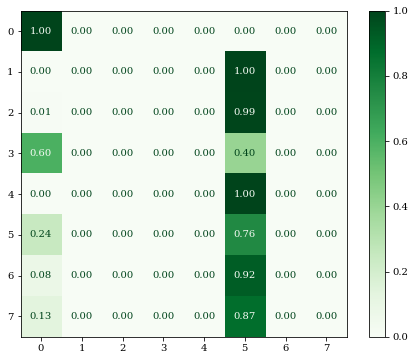

In [9]:
# docs/ST_stage2_normal_wav2vec2_vib_normal_mlaad_stage2_acoustic_epoch3.txt
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'Mars5', 2: 'Metavoice', 3: 'bark', 4: 'f_pitch', 5: 's-speech', 6: 'T2', 7: 'vits', 8: 'xtts_v1.1', 9: 'xtts_v2'}
pred_df = pd.read_csv("docs/ST_stage2_normal_wav2vec2_vib_normal_mlaad_stage2_acoustic_epoch3.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df)
pred_df.columns = ["path", "pred", "pred_score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(mlaad_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['acoustic'].isin(seen_classes)
print(res_df['seen'].value_counts())
# res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
# res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
# res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)


# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# visualize the AUC
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(res_df['seen'], res_df['pred_score'])
# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/precision.npy', precision)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/recall.npy', recall)

# # save the tpr, fpr, threshold
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/tpr.npy', tpr)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/fpr.npy', fpr)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/threshold.npy', threshold)
# plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")


# The OOD EER
# calculate the EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['acoustic'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['acoustic'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)

# Update default font properties
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# Calculate percentage of each class in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# fill nan with 0
cm_percentage = np.nan_to_num(cm_percentage)
# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp.plot(cmap='Greens', values_format='.2f', ax=ax)

# Customize labels and ticks
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16, fontweight='bold')  # Add a title
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# # Add text in each cell with contrasting color
# for i in range(cm_percentage.shape[0]):
#     for j in range(cm_percentage.shape[1]):
#         text_color = 'white' if cm_percentage[i, j] > 0.5 else 'black'  # Set text color based on background
#         ax.text(j, i, f"{cm_percentage[i, j]:.2f}", ha='center', va='center', color=text_color, fontsize=12)

# Add gridlines for better readability
ax.grid(False)  # Disable the default grid
ax.set_axisbelow(True)  # Ensure grid is below the heatmap
ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

# Save the figure
# plt.savefig('figs/E2E_acoustic_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



                                                       0  1         2
0      fake/pt/tts_models_multilingual_multi-dataset_...  0  0.128211
1      fake/pt/tts_models_multilingual_multi-dataset_...  0  0.128203
2      fake/pt/tts_models_multilingual_multi-dataset_...  0  0.128235
3      fake/pt/tts_models_multilingual_multi-dataset_...  0  0.128203
4      fake/pt/tts_models_multilingual_multi-dataset_...  0  0.128168
...                                                  ... ..       ...
62941        CommonVoice/de/common_voice_de_19837507.wav  0  0.128270
62942        CommonVoice/en/common_voice_en_27240622.wav  0  0.128149
62943        CommonVoice/de/common_voice_de_21149754.wav  0  0.128131
62944        CommonVoice/ja/common_voice_ja_36298016.wav  0  0.128189
62945        CommonVoice/fr/common_voice_fr_20316840.wav  0  0.128134

[62946 rows x 3 columns]
True     59285
False     3879
Name: seen, dtype: int64
AUC:  0.4186635497781057
AUPR:  0.9247598777698036
EER:  0.5575557032727134
(59

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (10).

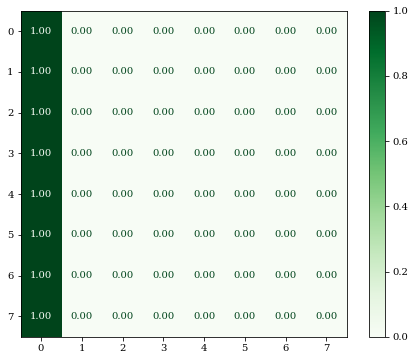

In [63]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch9/
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'Mars5', 2: 'Metavoice', 3: 'bark', 4: 'f_pitch', 5: 's-speech', 6: 'T2', 7: 'vits', 8: 'xtts_v1.1', 9: 'xtts_v2'}
pred_df = pd.read_csv("docs/ST_stage2_normal_wav2vec2_vib_normal_mlaad_stage2_acoustic_epoch0.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df)
pred_df.columns = ["path", "pred", "pred_score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(mlaad_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['acoustic'].isin(seen_classes)
print(res_df['seen'].value_counts())
# res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
# res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
# res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)


# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# visualize the AUC
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(res_df['seen'], res_df['pred_score'])
# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/precision.npy', precision)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/recall.npy', recall)

# # save the tpr, fpr, threshold
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/tpr.npy', tpr)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/fpr.npy', fpr)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/threshold.npy', threshold)
# plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")


# The OOD EER
# calculate the EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['acoustic'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['acoustic'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)

# Update default font properties
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# Calculate percentage of each class in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# fill nan with 0
cm_percentage = np.nan_to_num(cm_percentage)
# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp.plot(cmap='Greens', values_format='.2f', ax=ax)

# Customize labels and ticks
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16, fontweight='bold')  # Add a title
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# # Add text in each cell with contrasting color
# for i in range(cm_percentage.shape[0]):
#     for j in range(cm_percentage.shape[1]):
#         text_color = 'white' if cm_percentage[i, j] > 0.5 else 'black'  # Set text color based on background
#         ax.text(j, i, f"{cm_percentage[i, j]:.2f}", ha='center', va='center', color=text_color, fontsize=12)

# Add gridlines for better readability
ax.grid(False)  # Disable the default grid
ax.set_axisbelow(True)  # Ensure grid is below the heatmap
ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

# Save the figure
# plt.savefig('figs/E2E_acoustic_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



                                                       0  1    2
0      fake/pt/tts_models_multilingual_multi-dataset_...  7  1.0
1      fake/pt/tts_models_multilingual_multi-dataset_...  7  1.0
2      fake/pt/tts_models_multilingual_multi-dataset_...  7  1.0
3      fake/pt/tts_models_multilingual_multi-dataset_...  7  1.0
4      fake/pt/tts_models_multilingual_multi-dataset_...  7  1.0
...                                                  ... ..  ...
62941        CommonVoice/de/common_voice_de_19837507.wav  0  1.0
62942        CommonVoice/en/common_voice_en_27240622.wav  0  1.0
62943        CommonVoice/de/common_voice_de_21149754.wav  0  1.0
62944        CommonVoice/ja/common_voice_ja_36298016.wav  0  1.0
62945        CommonVoice/fr/common_voice_fr_20316840.wav  0  1.0

[62946 rows x 3 columns]
True     59285
False     3879
Name: seen, dtype: int64
AUC:  0.49815630114671255
AUPR:  0.9690346499592826
EER:  0.9987145324179044
(59285, 19)
ACC:  0.670911697731298
G-F1:  0.529229948329962
M

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (10).

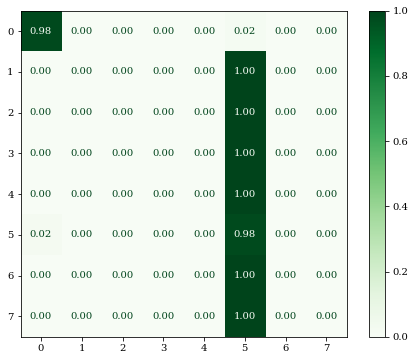

In [54]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch9/
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'Mars5', 2: 'Metavoice', 3: 'bark', 4: 'f_pitch', 5: 's-speech', 6: 'T2', 7: 'vits', 8: 'xtts_v1.1', 9: 'xtts_v2'}
pred_df = pd.read_csv("docs/ST_stage2_normal_wav2vec2_aasist_normal_mlaad_stage2_acoustic_epoch1.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df)
pred_df.columns = ["path", "pred", "pred_score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(mlaad_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['acoustic'].isin(seen_classes)
print(res_df['seen'].value_counts())
# res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
# res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
# res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)


# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# visualize the AUC
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(res_df['seen'], res_df['pred_score'])
# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/precision.npy', precision)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/recall.npy', recall)

# # save the tpr, fpr, threshold
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/tpr.npy', tpr)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/fpr.npy', fpr)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/threshold.npy', threshold)
# plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")


# The OOD EER
# calculate the EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['acoustic'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['acoustic'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)

# Update default font properties
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# Calculate percentage of each class in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# fill nan with 0
cm_percentage = np.nan_to_num(cm_percentage)
# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp.plot(cmap='Greens', values_format='.2f', ax=ax)

# Customize labels and ticks
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16, fontweight='bold')  # Add a title
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# # Add text in each cell with contrasting color
# for i in range(cm_percentage.shape[0]):
#     for j in range(cm_percentage.shape[1]):
#         text_color = 'white' if cm_percentage[i, j] > 0.5 else 'black'  # Set text color based on background
#         ax.text(j, i, f"{cm_percentage[i, j]:.2f}", ha='center', va='center', color=text_color, fontsize=12)

# Add gridlines for better readability
ax.grid(False)  # Disable the default grid
ax.set_axisbelow(True)  # Ensure grid is below the heatmap
ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

# Save the figure
# plt.savefig('figs/E2E_acoustic_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



(62946, 4)
807
True     59067
False     3879
Name: seen, dtype: int64
AUC:  0.8055681198833317
AUPR:  0.9840366092811447
EER:  0.2771211637168331
(59067, 8)
ACC:  0.6685458885672203
G-F1:  0.6145069225141021
Micro-F1:  0.6685458885672203
Macro-F1:  0.39000427996346254
Confusion matrix:  [[27827     6    55     0     1     0   111   298  1686   912]
 [    6    19     5     0     0     0     9    24    28   206]
 [   39    38    71     0     0     0    10     8   103    28]
 [ 1521   103    79     0     3     3   157  1025  1713  3196]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [  192    63     2     0     7   488   680   551    19   393]
 [  368    28     1     0     2   151   343  4471   599  3619]
 [   28     0     0     0     0     0     1     0  2743  1128]
 [   24     0     0     0     0     0     0   132    66  3678]]
{'-': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech':

/tmp/ipykernel_2944562/848054156.py:71: RuntimeWarning: invalid value encountered in true_divide
  cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]


<Figure size 720x720 with 0 Axes>

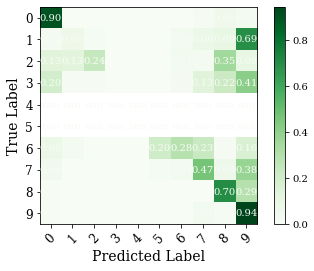

In [52]:
# Baseline acoustic
# display map is the label exist in the dataset
display_map = {'Real': 0 , 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 'tacotron2': 6, 'vits': 7, 'xtts_v1.1': 8, 'xtts_v2': 9}
pred_df = pd.read_csv("/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/scores_eval.txt", sep=" ", header=None, usecols=[0, 1, 2, 3])
print(pred_df.shape)
pred_df.columns = ["label", "file_name", "pred", "pred_score"]
pred_df=pred_df[pred_df['file_name'].str.contains('original')]
pred_df['utt']=pred_df['file_name'].apply(lambda x: x.replace('.pt', '').replace('original_', ''))
pred_df['acoustic'] = pred_df['label'].map(map_label)
print(pred_df.duplicated(subset=['utt', 'acoustic']).sum())
pred_df['pred_name'] = pred_df['pred'].map(map_label)
acoustic_df['utt'] = acoustic_df['path'].apply(lambda x: x.split('/')[-1].split('.')[0])
# print(acoustic_df.shape)
# print(acoustic_df.duplicated(subset=['utt']).sum())
# res_df = pd.merge(acoustic_df, pred_df, on=['utt', 'acoustic'], how='inner')
res_df = pred_df.copy()
res_df['seen'] = False
res_df.loc[res_df['acoustic'].isin(seen_classes), 'seen'] = True

print(res_df['seen'].value_counts())

# calculate AUC for OOD detection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
tpr, fpr, threshold = roc_curve(res_df['seen'], res_df['pred_score'])
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
np.save('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/precision.npy', precision)
np.save('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/recall.npy', recall)

# save the tpr, fpr, threshold
np.save('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/tpr.npy', tpr)
np.save('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/fpr.npy', fpr)
np.save('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/threshold.npy', threshold)

# calculate EER for OOD detection
seen_scores = res_df[res_df['seen']==True]['pred_score'].values
unseen_scores = res_df[res_df['seen']==False]['pred_score'].values
eer, _ = compute_eer(seen_scores, unseen_scores)
print("EER: ", eer)
# filter only seen classes
res_seen_df = res_df[res_df['acoustic'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['acoustic'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# visualize confusion matrix
# display the percenntage of each class in the confusion matrix
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

plt.figure(figsize=(10, 10))
cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())
disp.plot(cmap='Greens', values_format='.2f')
# Change label font size
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# Rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('figs/baseline_acoustic_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



(62946, 3)
True     59285
False     3879
Name: seen, dtype: int64
AUC:  0.8588185936548197
AUPR:  0.9897439477166349
EER:  0.2645015710221986
(59285, 20)
ACC:  0.9164544151134351
G-F1:  0.8850581769094147
Micro-F1:  0.9164544151134351
Macro-F1:  0.8053764851667566
Confusion matrix:  [[30823     1    15    18     0     1     6    14     3    15]
 [    0   295     0     2     0     0     0     0     0     0]
 [    0     4   291     2     0     0     0     0     0     0]
 [   19   831    10  6741     1     0    17    95    11   185]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0   495     3    25     4     0  1901     2     1    72]
 [  446   626    29   316     1    12   364  6494   122  1172]
 [    0     1     0     0     0     0     0     2  3892     5]
 [    3     1     0     0     0     0     0     0     1  3895]]
{'-': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 

/tmp/ipykernel_22575/96229684.py:81: RuntimeWarning: invalid value encountered in true_divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


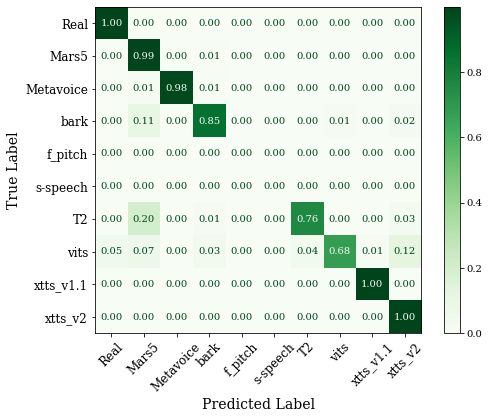

In [50]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch9/
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'Mars5', 2: 'Metavoice', 3: 'bark', 4: 'f_pitch', 5: 's-speech', 6: 'T2', 7: 'vits', 8: 'xtts_v1.1', 9: 'xtts_v2'}
pred_df = pd.read_csv("docs/ST_E2E_augall_wav2vec2_aasist_normal_mlaad_acoustic_epoch25/scores.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df.shape)
pred_df.columns = ["path", "pred", "score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(mlaad_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['acoustic'].isin(seen_classes)
print(res_df['seen'].value_counts())
res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)


# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# visualize the AUC
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(res_df['seen'], res_df['pred_score'])
# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/precision.npy', precision)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/recall.npy', recall)

# # save the tpr, fpr, threshold
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/tpr.npy', tpr)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/fpr.npy', fpr)
# np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/threshold.npy', threshold)
# plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")


# The OOD EER
# calculate the EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['acoustic'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['acoustic'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)

# Update default font properties
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# Calculate percentage of each class in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# fill nan with 0
cm_percentage = np.nan_to_num(cm_percentage)
# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp.plot(cmap='Greens', values_format='.2f', ax=ax)

# Customize labels and ticks
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16, fontweight='bold')  # Add a title
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# # Add text in each cell with contrasting color
# for i in range(cm_percentage.shape[0]):
#     for j in range(cm_percentage.shape[1]):
#         text_color = 'white' if cm_percentage[i, j] > 0.5 else 'black'  # Set text color based on background
#         ax.text(j, i, f"{cm_percentage[i, j]:.2f}", ha='center', va='center', color=text_color, fontsize=12)

# Add gridlines for better readability
ax.grid(False)  # Disable the default grid
ax.set_axisbelow(True)  # Ensure grid is below the heatmap
ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

# Save the figure
# plt.savefig('figs/E2E_acoustic_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



(62946, 3)
True     59285
False     3879
Name: seen, dtype: int64
AUC:  0.8524501795402691
AUPR:  0.9815164275756552
EER:  0.1856133620149003
(59285, 20)
ACC:  0.8645863203171122
G-F1:  0.8555566777408476
Micro-F1:  0.8645863203171122
Macro-F1:  0.7910082428639695
Confusion matrix:  [[30759    12     8    67     0     0     0    41     8     1]
 [    0   294     0     1     1     0     0     1     0     0]
 [    1     0   296     0     0     0     0     0     0     0]
 [  586     1     0  6856     0     0     9   176    91   191]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    4   480    12    17    33     4  1850    32    10    61]
 [ 3050   150     0    30    42    14   326  3455    55  2460]
 [    1     0     0     0     0     0     0     2  3890     7]
 [   35     1     0     0     1     0     0     3     3  3857]]
{'-': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 

/tmp/ipykernel_22575/2912926988.py:81: RuntimeWarning: invalid value encountered in true_divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


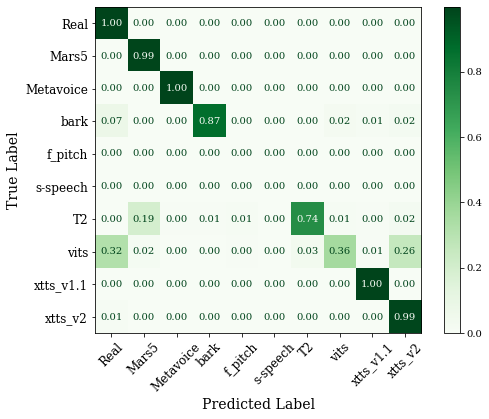

In [36]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch9/
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'Mars5', 2: 'Metavoice', 3: 'bark', 4: 'f_pitch', 5: 's-speech', 6: 'T2', 7: 'vits', 8: 'xtts_v1.1', 9: 'xtts_v2'}
pred_df = pd.read_csv("docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/scores.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df.shape)
pred_df.columns = ["path", "pred", "score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(mlaad_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['acoustic'].isin(seen_classes)
print(res_df['seen'].value_counts())
res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)


# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# visualize the AUC
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(res_df['seen'], res_df['pred_score'])
# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/precision.npy', precision)
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/recall.npy', recall)

# save the tpr, fpr, threshold
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/tpr.npy', tpr)
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/fpr.npy', fpr)
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/threshold.npy', threshold)
# plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")


# The OOD EER
# calculate the EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['acoustic'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['acoustic'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)

# Update default font properties
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# Calculate percentage of each class in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# fill nan with 0
cm_percentage = np.nan_to_num(cm_percentage)
# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp.plot(cmap='Greens', values_format='.2f', ax=ax)

# Customize labels and ticks
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16, fontweight='bold')  # Add a title
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# # Add text in each cell with contrasting color
# for i in range(cm_percentage.shape[0]):
#     for j in range(cm_percentage.shape[1]):
#         text_color = 'white' if cm_percentage[i, j] > 0.5 else 'black'  # Set text color based on background
#         ax.text(j, i, f"{cm_percentage[i, j]:.2f}", ha='center', va='center', color=text_color, fontsize=12)

# Add gridlines for better readability
ax.grid(False)  # Disable the default grid
ax.set_axisbelow(True)  # Ensure grid is below the heatmap
ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

# Save the figure
plt.savefig('figs/E2E_acoustic_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



In [43]:
# res_df[(res_df['acoustic']=='vits') & (res_df['pred_name']=='vits') & (res_df['subset']=='eval')]['model_name'].value_counts()
mlaad_df[(mlaad_df['acoustic']=='vits')]['model_name'].value_counts()

OpenVoiceV2                          898
tts_models/en/ljspeech/vits--neon    691
tts_models/it/mai_male/vits          600
tts_models/de/css10/vits-neon        600
tts_models/it/mai_female/vits        600
tts_models/fr/css10/vits             600
tts_models/lt/cv/vits                599
MeloTTS                              598
facebook/mms-tts-deu                 595
facebook/mms-tts-eng                 300
tts_models/bg/cv/vits                300
tts_models/ro/cv/vits                300
tts_models/hu/css10/vits             300
tts_models/pl/mai_female/vits        300
tts_models/lv/cv/vits                300
facebook/mms-tts-fin                 300
tts_models/fi/css10/vits             300
tts_models/el/cv/vits                300
facebook/mms-tts-nld                 300
tts_models/de/thorsten/vits          300
tts_models/en/jenny/jenny            300
facebook/mms-tts-fra                 300
tts_models/et/cv/vits                300
tts_models/cs/cv/vits                300
tts_models/es/cs

(62946, 3)
AUC:  0.8096678401201148
EER:  0.2485567127022819
(59285, 8)
ACC:  0.5223581007000084
G-F1:  0.4891682898620076
Micro-F1:  0.5223581007000084
Macro-F1:  0.12636874420821376
Confusion matrix:  [[30696   197     3     0     0     0     0     0]
 [    5   187   105     0     0     0     0     0]
 [    3   209    85     0     0     0     0     0]
 [ 1130  5209  1571     0     0     0     0     0]
 [    4   820  1679     0     0     0     0     0]
 [  333  3073  6176     0     0     0     0     0]
 [   26  3606   268     0     0     0     0     0]
 [    9  3819    72     0     0     0     0     0]]
{'-': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 'tacotron2': 6, 'vits': 7, 'xtts_v1.1': 8, 'xtts_v2': 9, 'glow-tts': 10, 'overflow': 11, 'WhisperSpeech': 12, 'parler': 13, 'tortoise': 14, 'MatchaTTS': 15, 'optispeech': 16, 'f5-tts': 17, 'e2-tts': 18, 'neural_hmm': 19, 'speecht5': 20}


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (10).

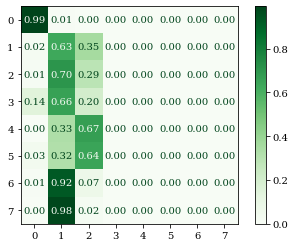

In [8]:
# docs/E2E_augall_rawnet3_vib_sclnormal_1.0CE_mlaad_acoustic_epoch18/
pred_df = pd.read_csv("docs/E2E_augall_rawnet3_vib_sclnormal_1.0CE_mlaad_acoustic_epoch18/scores.txt", sep=" ", header=None, usecols=[0,1,2])
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch9/
# display map is the label exist in the dataset
display_map = {0: '-', 1: 'Mars5', 2: 'Metavoice', 3: 'bark', 4: 'fast_pitch', 5: 'speedy-speech', 6: 'tacotron2', 7: 'vits', 8: 'xtts_v1.1', 9: 'xtts_v2'}
# pred_df = pd.read_csv("docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch9/scores.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df.shape)
pred_df.columns = ["path", "pred", "score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(acoustic_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['acoustic'].isin(seen_classes)
res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)


# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# visualize the AUC
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(res_df['seen'], res_df['pred_score'])
# save the fpr, tpr, threshold
# plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")


# The OOD EER
# calculate the EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['acoustic'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['acoustic'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# visualize confusion matrix
# display the percenntage of each class in the confusion matrix
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})


cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())
disp.plot(cmap='Greens', values_format='.2f')
# Change label font size
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# Rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
# 
# plt.savefig('figs/E2E_acoustic_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



(59285, 6)
ACC:  0.6691237243822215
G-F1:  0.5237408710643771
Micro-F1:  0.6691237243822215
Macro-F1:  0.18226117234820527
Confusion matrix:  [[30886     0    10     0     0     0     0     0]
 [   27     0  3873     0     0     0     0     0]
 [  799     0  8783     0     0     0     0     0]
 [    1     0  2502     0     0     0     0     0]
 [    7     0  3893     0     0     0     0     0]
 [    1     0   296     0     0     0     0     0]
 [    2     0   295     0     0     0     0     0]
 [  475     0  7435     0     0     0     0     0]]


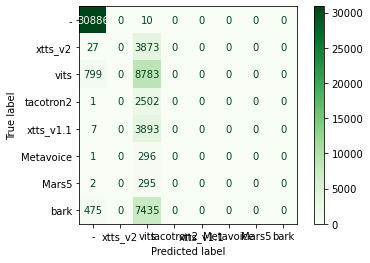

In [8]:
pred_df = pd.read_csv("docs/ST_2stage_augall_rawnet3_vib_sclnormal_0.1CE_mlaad_stage2_epoch17_acoustic_epoch2/scores.txt", sep=" ", header=None, usecols=[0,1,2])
pred_df.columns = ["path", "pred", "score"]

res_df = pd.merge(acoustic_df, pred_df, on='path', how='inner')
print(res_df.shape)

# calculate ACC, F1-score
y_true = res_df['label'].values
y_pred = res_df['pred'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)

# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=map_label.keys())
disp.plot(cmap='Greens', values_format='g')
plt.show()

(59288, 6)
ACC:  0.6778943462420726
G-F1:  0.531701142257158
Micro-F1:  0.6778943462420726
Macro-F1:  0.18625727601716963
Confusion matrix:  [[30836     6    54     0     0     0     0     0]
 [    6     0  3897     0     0     0     0     0]
 [  215    12  9355     0     0     0     0     0]
 [    0     0  2503     0     0     0     0     0]
 [    0     0  3900     0     0     0     0     0]
 [    0     0   297     0     0     0     0     0]
 [    0     0   297     0     0     0     0     0]
 [  198     9  7703     0     0     0     0     0]]


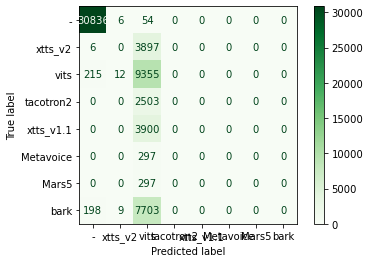

In [85]:
### AASIST-SSL sclnormal
pred_df = pd.read_csv("/dataa/phucdt/vocodetect/Supcon-voco/docs/ST_2stage_augall_wav2vec2_vib_sclnormal_0.1CE_mlaad_acoustic_stage2_epoch3/scores.txt", sep=" ", header=None)
pred_df.columns = ["path", "pred", "score"]

res_df = pd.merge(acoustic_df, pred_df, on='path', how='inner')
print(res_df.shape)

# calculate ACC, F1-score
y_true = res_df['label'].values
y_pred = res_df['pred'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)

# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=map_label.keys())
disp.plot(cmap='Greens', values_format='g')
plt.show()

(59285, 6)
ACC:  0.6765117652019904
G-F1:  0.5322880939433463
Micro-F1:  0.6765117652019904
Confusion matrix:  [[30843    28    25     0     0     0     0     0]
 [    2     1  3897     0     0     0     0     0]
 [  176   143  9263     0     0     0     0     0]
 [    0     0  2503     0     0     0     0     0]
 [    0     1  3899     0     0     0     0     0]
 [    0     0   297     0     0     0     0     0]
 [    1     0   296     0     0     0     0     0]
 [  152    83  7675     0     0     0     0     0]]


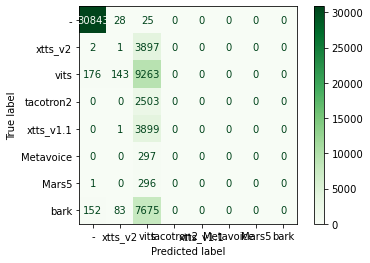

In [63]:
### AASIST-SSL sclnormal
pred_df = pd.read_csv("docs/E2E_augall_wav2vec2_vib_sclnormal_1.0CE_mlaad_acoustic_epoch16/scores.txt", sep=" ", header=None)
pred_df.columns = ["path", "pred", "score"]

res_df = pd.merge(acoustic_df, pred_df, on='path', how='inner')
print(res_df.shape)

# calculate ACC, F1-score
y_true = res_df['label'].values
y_pred = res_df['pred'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Confusion matrix: ", cm)
# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=map_label.keys())
disp.plot(cmap='Greens', values_format='g')
plt.show()


(59285, 6)
ACC:  0.6006072362317618
G-F1:  0.5371427905156756
Micro-F1:  0.6006072362317618
Confusion matrix:  [[30872     4     8     5     0     0     0     7     0     0]
 [    1  3888    11     0     0     0     0     0     0     0]
 [ 1770  7160   502   131     0     0     9    10     0     0]
 [    0   230  1940   329     2     0     0     2     0     0]
 [    0     0  3899     0     0     0     0     1     0     0]
 [    0     0     0   297     0     0     0     0     0     0]
 [    0     1     2   294     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [  127   130    40   641     0     0     3  6952     1    16]]


/tmp/ipykernel_3959886/1014011684.py:21: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


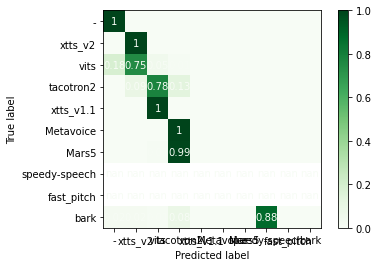

In [70]:
### AASIST-SSL sclnormal
pred_df = pd.read_csv("docs/E2E_Fair_augall_wav2vec2_vib_sclnormal_1.0CE_mlaad_acoustic_epoch17/scores.txt", sep=" ", header=None)
pred_df.columns = ["path", "pred", "score"]

res_df = pd.merge(acoustic_df, pred_df, on='path', how='inner')
print(res_df.shape)

# calculate ACC, F1-score
y_true = res_df['label'].values
y_pred = res_df['pred'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Confusion matrix: ", cm)

# convert confusion matrix to percentage
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.round(cm, 2)
# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap='Greens', values_format='g')
plt.show()


# Vocoder

In [59]:
# mlaad_df = mlaad_df[mlaad_df['vocoder']!='unknown']
vocoder_df = mlaad_df.copy()[['path', 'vocoder', 'subset', 'model_name']]
vocoder_df = vocoder_df[vocoder_df['vocoder']!='unknown']
seen_classes = vocoder_df[vocoder_df['subset']=='train']['vocoder'].unique()
seen_classes = np.sort(seen_classes)
label_map = {seen_classes[i]: i for i in range(len(seen_classes))}
print(label_map)
t = len(label_map)
classes = vocoder_df['vocoder'].unique()
for c in classes:
    if c not in label_map:
        label_map[c] = t
        t += 1
print(label_map)
# map_label is reverse of label_map
map_label = {v: k for k, v in label_map.items()}
print(map_label)

# vocoder_df['label'] = mlaad_df['vocoder'].map(label_map)
# fill NA with -1
# vocoder_df = vocoder_df.fillna(-1)
# label_idx = vocoder_df['label'].unique()
# set the label column type to int
# vocoder_df['label'] = vocoder_df['label'].astype(int)
vocoder_df=vocoder_df[vocoder_df['subset']=='eval']
# vocoder_df = vocoder_df[vocoder_df['label']!=-1]
# map_label = {k: v for k, v in label_map.items() if v in label_idx}
print(vocoder_df)


{'-': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6}
{'-': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'vocos': 7, 'dac': 8, 'wavenext': 9, 'wavegrad': 10, 'bigvgan': 11}
{0: '-', 1: 'bark', 2: 'fullband-melgan', 3: 'hifigan', 4: 'melgan', 5: 'multi-melgan', 6: 'univnet', 7: 'vocos', 8: 'dac', 9: 'wavenext', 10: 'wavegrad', 11: 'bigvgan'}
                                                     path  vocoder subset  \
0       fake/pt/tts_models_multilingual_multi-dataset_...  hifigan   eval   
1       fake/pt/tts_models_multilingual_multi-dataset_...  hifigan   eval   
2       fake/pt/tts_models_multilingual_multi-dataset_...  hifigan   eval   
3       fake/pt/tts_models_multilingual_multi-dataset_...  hifigan   eval   
4       fake/pt/tts_models_multilingual_multi-dataset_...  hifigan   eval   
...                                                   ...      ...    ...   
102918        Commo

In [102]:
vocoder = mlaad_df['vocoder'].unique()
for vc in vocoder:
    trn = mlaad_df[(mlaad_df['vocoder']==vc) & (mlaad_df['subset']=='train')].shape[0]
    dev = mlaad_df[(mlaad_df['vocoder']==vc) & (mlaad_df['subset']=='dev')].shape[0]
    eval = mlaad_df[(mlaad_df['vocoder']==vc) & (mlaad_df['subset']=='eval')].shape[0]
    print(f'{vc},{trn},{dev},{eval}')

hifigan,5548,6296,15430
bark,300,2400,7800
univnet,1946,300,4644
fullband-melgan,299,299,597
multi-melgan,299,0,899
vocos,0,299,593
dac,0,300,598


unknown,593,0,594
wavenext,0,0,298
melgan,300,300,0
wavegrad,0,0,300
bigvgan,0,0,297
-,10300,10200,30896


In [103]:
unseen_df = vocoder_df[~vocoder_df['vocoder'].isin(seen_classes)]
unseen_df=unseen_df[unseen_df['subset']=='eval']
unseen_df.shape

(2086, 4)

In [100]:
map_label.values()

dict_values(['-', 'bark', 'fullband-melgan', 'hifigan', 'melgan', 'multi-melgan', 'univnet', 'unknown', 'vocos', 'dac', 'wavenext', 'wavegrad', 'bigvgan'])

(62946, 3)
True     60484
False     2086
Name: seen, dtype: int64
AUC:  0.2748683431124437
AUPR:  0.9457836957691778
EER:  0.670179701890845
(60484, 9)
ACC:  0.6330765161034323
G-F1:  0.5289687197260238
Micro-F1:  0.6330765161034323
Macro-F1:  0.23118081214232863
Confusion matrix:  [[30893     3     0     0     0     0]
 [  512  7398     0     0     0     0]
 [    2   595     0     0     0     0]
 [  952 14478     0     0     0     0]
 [    0   899     0     0     0     0]
 [   73  4679     0     0     0     0]]
{'-': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'vocos': 7, 'dac': 8, 'wavenext': 9, 'wavegrad': 10, 'bigvgan': 11}


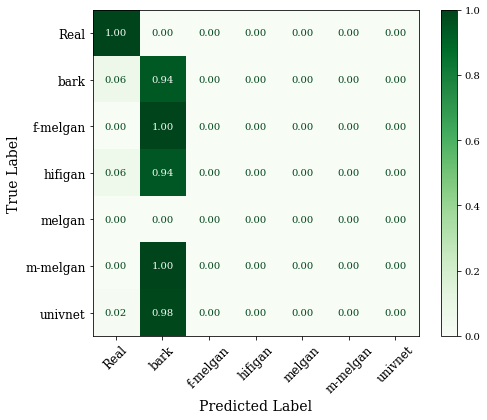

In [61]:
# Supcon-voco/docs/ST_2stage_augall_rawnet3_vib_sclnormal_0.1CE_mlaad_stage2_epoch17_vocoder_epoch8/scores.txt
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'bark', 2: 'f-melgan', 3: 'hifigan', 4: 'melgan', 5: 'm-melgan', 6: 'univnet'}
pred_df = pd.read_csv("docs/ST_2stage_augall_rawnet3_vib_sclnormal_0.1CE_mlaad_stage2_epoch17_vocoder_epoch8/scores.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df.shape)
pred_df.columns = ["path", "pred", "score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(vocoder_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['vocoder'].isin(seen_classes)
print(res_df['seen'].value_counts())
res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)


# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/precision.npy', precision)
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/recall.npy', recall)
# print(fpr, tpr, thresholds)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# The OOD EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['vocoder'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['vocoder'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# visualize confusion matrix
# display the percenntage of each class in the confusion matrix
# Update default font properties
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# Calculate percentage of each class in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# add the column and row for class number 4
cm_percentage = np.insert(cm_percentage, 4, 0, axis=1)
cm_percentage = np.insert(cm_percentage, 4, 0, axis=0)
# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp.plot(cmap='Greens', values_format='.2f', ax=ax)

# Customize labels and ticks
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16, fontweight='bold')  # Add a title
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
ax.grid(False)  # Disable the default grid
ax.set_axisbelow(True)  # Ensure grid is below the heatmap
ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

plt.savefig('figs/E2E_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)

(62946, 3)
True     60484
False     2086
Name: seen, dtype: int64
AUC:  0.4984202853770889
AUPR:  0.9832109310215192
EER:  0.9990411479707667
(60484, 8)
ACC:  0.7557535877256795
G-F1:  0.5617883412253988
Micro-F1:  0.7557535877256795
Macro-F1:  0.27658754549060355
Confusion matrix:  [[30751     0     0   145     0     0]
 [   30     0     0  7880     0     0]
 [    0     0     0   597     0     0]
 [  470     0     0 14960     0     0]
 [    1     0     0   898     0     0]
 [    1     0     0  4751     0     0]]
{'-': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'vocos': 7, 'dac': 8, 'wavenext': 9, 'wavegrad': 10, 'bigvgan': 11}


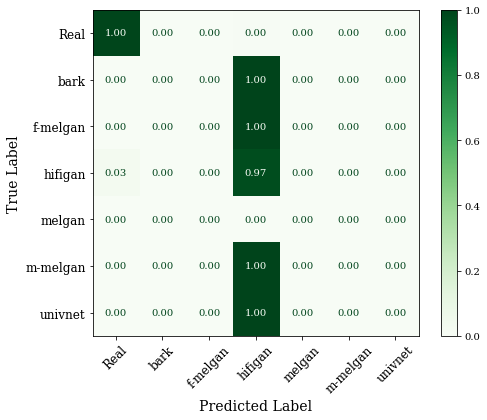

In [56]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'bark', 2: 'f-melgan', 3: 'hifigan', 4: 'melgan', 5: 'm-melgan', 6: 'univnet'}
pred_df = pd.read_csv("docs/ST_stage2_normal_wav2vec2_aasist_normal_mlaad_stage2_vocoder_epoch1.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df.shape)
pred_df.columns = ["path", "pred", "pred_score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(vocoder_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['vocoder'].isin(seen_classes)
print(res_df['seen'].value_counts())

# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/precision.npy', precision)
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/recall.npy', recall)
# print(fpr, tpr, thresholds)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# The OOD EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['vocoder'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['vocoder'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# visualize confusion matrix
# display the percenntage of each class in the confusion matrix
# Update default font properties
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# Calculate percentage of each class in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# add the column and row for class number 4
cm_percentage = np.insert(cm_percentage, 4, 0, axis=1)
cm_percentage = np.insert(cm_percentage, 4, 0, axis=0)
# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp.plot(cmap='Greens', values_format='.2f', ax=ax)

# Customize labels and ticks
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16, fontweight='bold')  # Add a title
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
ax.grid(False)  # Disable the default grid
ax.set_axisbelow(True)  # Ensure grid is below the heatmap
ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

plt.savefig('figs/E2E_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)

True     60266
False     2680
Name: seen, dtype: int64
AUPR:  0.9900513035855164
EER:  0.24932404152535698
AUC:  0.8164029580798757
(60266, 8)
ACC:  0.761026117545548
G-F1:  0.673701600481463
Micro-F1:  0.761026117545548
Macro-F1:  0.49996432529918383
Confusion matrix:  [[28900   366     3   830     1   796]
 [ 1283   565    10  3163     3  2776]
 [    4     2   255   332     0     4]
 [  743   274     4 12100     5  2304]
 [    2    31     0   821    35    10]
 [   36   172     1   425     1  4009]]
{'-': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'vocos': 7, 'dac': 8, 'wavenext': 9, 'wavegrad': 10, 'bigvgan': 11}


<Figure size 720x720 with 0 Axes>

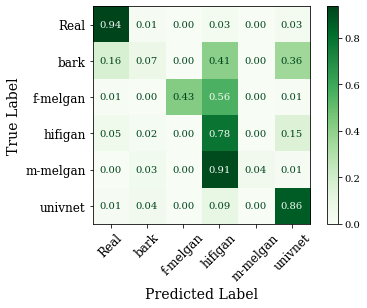

In [44]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'bark', 2: 'f-melgan', 3: 'hifigan', 5: 'm-melgan', 6: 'univnet'}
pred_df = pd.read_csv("/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/scores_eval.txt", sep=" ", header=None, usecols=[0, 1, 2, 3])
# print(pred_df.shape)
pred_df.columns = ["label", "file_name", "pred", "pred_score"]
pred_df['utt']=pred_df['file_name'].apply(lambda x: x.replace('original_', '').replace('.pt', ''))
pred_df['vocoder'] = pred_df['label'].map(map_label)
pred_df['pred_name'] = pred_df['pred'].map(map_label)
# vocoder_df['utt'] = vocoder_df['path'].apply(lambda x: x.split('/')[-1].split('.')[0])
# print(vocoder_df.shape)
# print(vocoder_df.duplicated(subset=['utt']).sum())
# res_df = pd.merge(vocoder_df, pred_df, on=['utt', 'vocoder'], how='inner')
res_df = pred_df.copy()
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['vocoder'].isin(seen_classes)
print(res_df['seen'].value_counts())
# res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
# res_df['pred_score'] = res_df['pred_score'].apply(lambda x: [float(i) for i in x])
# res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)

# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
np.save('/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/precision.npy', precision)
np.save('/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/recall.npy', recall)

# The OOD EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)


# filter only seen classes
res_seen_df = res_df[res_df['vocoder'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['vocoder'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# visualize confusion matrix
# display the percenntage of each class in the confusion matrix
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

plt.figure(figsize=(10, 10))
cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())
disp.plot(cmap='Greens', values_format='.2f')
# Change label font size
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# Rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('figs/baseline_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



(62946, 3)
True     60484
False     2086
Name: seen, dtype: int64
AUC:  0.7753539909098881
AUPR:  0.9905476078293608
EER:  0.36528955654175527
(60484, 9)
ACC:  0.858491501884796
G-F1:  0.7622259217098304
Micro-F1:  0.858491501884796
Macro-F1:  0.6257903482942405
Confusion matrix:  [[30696    92     0    30     0    78]
 [ 1160  3399     3  1796     0  1552]
 [    0     0   299   288     0    10]
 [  740   689     0 13459     0   542]
 [    0     5     0   815     0    79]
 [    3   119     0   558     0  4072]]
{'-': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'vocos': 7, 'dac': 8, 'wavenext': 9, 'wavegrad': 10, 'bigvgan': 11}


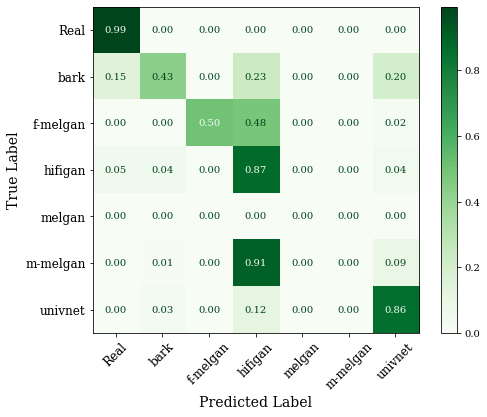

In [8]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'bark', 2: 'f-melgan', 3: 'hifigan', 4: 'melgan', 5: 'm-melgan', 6: 'univnet'}
pred_df = pd.read_csv("docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/scores.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df.shape)
pred_df.columns = ["path", "pred", "score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)

res_df = pd.merge(vocoder_df, pred_df, on='path', how='inner')
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['vocoder'].isin(seen_classes)
print(res_df['seen'].value_counts())
res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)


# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)

# calculate AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(res_df['seen'], res_df['pred_score'])
aupr = auc(recall, precision)
print("AUPR: ", aupr)

# save the precision, recall
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/precision.npy', precision)
np.save('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/recall.npy', recall)
# print(fpr, tpr, thresholds)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# The OOD EER
seen_score = res_df[res_df['seen']==True]['pred_score'].values
unseen_score = res_df[res_df['seen']==False]['pred_score'].values
eer, threshold = compute_eer(seen_score, unseen_score)
print("EER: ", eer)

# filter only seen classes
res_seen_df = res_df[res_df['vocoder'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['vocoder'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# visualize confusion matrix
# display the percenntage of each class in the confusion matrix
# Update default font properties
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# Calculate percentage of each class in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# add the column and row for class number 4
cm_percentage = np.insert(cm_percentage, 4, 0, axis=1)
cm_percentage = np.insert(cm_percentage, 4, 0, axis=0)
# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
disp.plot(cmap='Greens', values_format='.2f', ax=ax)

# Customize labels and ticks
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16, fontweight='bold')  # Add a title
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
ax.grid(False)  # Disable the default grid
ax.set_axisbelow(True)  # Ensure grid is below the heatmap
ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

plt.savefig('figs/E2E_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)

In [24]:
res_df[(res_df['vocoder']=='bark') & (res_df['pred_name']!='bark')]['model_name'].value_counts()

tts_models/multilingual/multi-dataset/bark    4472
suno/bark-small                                 30
suno/bark                                        9
Name: model_name, dtype: int64

In [25]:
mlaad_df[(mlaad_df['vocoder']=='bark')&(mlaad_df['subset']=='eval')]['model_name'].value_counts()

tts_models/multilingual/multi-dataset/bark    7200
suno/bark-small                                456
suno/bark                                      144
Name: model_name, dtype: int64

In [38]:
map_label = {0: '-', 1: 'encodec', 2: 'fullband-melgan', 3: 'hifigan', 5: 'multi-melgan', 6: 'univnet', 4: 'melgan'}
print(map_label)
res_df['pred_name'] = res_df['pred'].map(map_label)
print(res_df['pred_name'].value_counts())

{0: '-', 1: 'encodec', 2: 'fullband-melgan', 3: 'hifigan', 5: 'multi-melgan', 6: 'univnet', 4: 'melgan'}
-                  32599
hifigan            17220
univnet             6365
encodec             4889
fullband-melgan      302
Name: pred_name, dtype: int64


In [26]:
vocoder = mlaad_df['vocoder'].unique()
for vc in vocoder:
    trn = mlaad_df[(mlaad_df['vocoder']==vc) & (mlaad_df['subset']=='train')].shape[0]
    dev = mlaad_df[(mlaad_df['vocoder']==vc) & (mlaad_df['subset']=='dev')].shape[0]
    eval = mlaad_df[(mlaad_df['vocoder']==vc) & (mlaad_df['subset']=='eval')].shape[0]
    print(f'{vc},{trn},{dev},{eval}')

hifigan,5548,6296,15430
bark,300,2400,7800
univnet,1946,300,4644
fullband-melgan,299,299,597
multi-melgan,299,0,899


vocos,0,299,593
dac,0,300,598
wavenext,0,0,298
melgan,300,300,0
wavegrad,0,0,300
bigvgan,0,0,297
-,10300,10200,30896


In [ ]:
acoustic = mlaad_df['acoustic'].unique()
for vc in acoustic:
    trn = mlaad_df[(mlaad_df['acoustic']==vc) & (mlaad_df['subset']=='train')].shape[0]
    dev = mlaad_df[(mlaad_df['acoustic']==vc) & (mlaad_df['subset']=='dev')].shape[0]
    eval = mlaad_df[(mlaad_df['acoustic']==vc) & (mlaad_df['subset']=='eval')].shape[0]
    print(f'{vc},{trn},{dev},{eval}')

xtts_v2,2400,1799,3900
vits,2394,3597,9582
bark,300,2400,7800
xtts_v1.1,1800,300,3900
glow-tts,0,0,899
tacotron2,1198,599,2395
overflow,0,0,300
WhisperSpeech,0,299,297
parler,0,300,598
tortoise,0,0,300
MatchaTTS,0,0,299
optispeech,0,0,298
f5-tts,0,0,296
speedy-speech,300,300,0
e2-tts,0,0,297
fast_pitch,300,300,0
neural_hmm,0,300,0
speecht5,0,0,295
-,10300,10200,30896


In [28]:
seen_classes

array(['-', 'Mars5', 'Metavoice', 'bark', 'fast_pitch', 'speedy-speech',
       'tacotron2', 'vits', 'xtts_v1.1', 'xtts_v2'], dtype=object)

(62946, 3)
(60484, 7)
ACC:  0.6363501091197672
G-F1:  0.5363913902793641
Micro-F1:  0.6363501091197672
Macro-F1:  0.23385461690497042
Confusion matrix:  [[30857    39     0     0     0     0]
 [  278  7632     0     0     0     0]
 [    0   597     0     0     0     0]
 [  294 15136     0     0     0     0]
 [    0   899     0     0     0     0]
 [    0  4752     0     0     0     0]]
{'-': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'vocos': 7, 'dac': 8, 'wavenext': 9, 'wavegrad': 10, 'bigvgan': 11}


<Figure size 720x720 with 0 Axes>

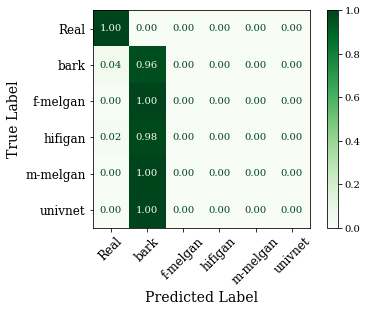

In [ ]:
# ST_2stage_augall_wav2vec2_vib_sclnormal_0.1CE_mlaad_vocoder_stage2_epoch25
# CUDA_VISIBLE_DEVICES=3  python train_ST.py --config configs/ST_2stage_augall_wav2vec2_vib_gelu_sclnormal.yaml --database_path ../traindata/mlaad_v5/ --batch_size 1 --padding_type "repeat" --max_lr 1e-2 --min_lr 1e-4  --comment "ST_2stage_augall_wav2vec2_vib_sclnormal_0.1CE_mlaad_vocoder_stage2" --model_path out/model_weighted_CCE_100_1_1e-06_ST_2stage_augall_wav2vec2_vib_sclnormal_0.1CE_mlaad/epoch_22.pth
# display map is the label exist in the dataset
display_map = {0: 'Real', 1: 'bark', 2: 'f-melgan', 3: 'hifigan', 5: 'm-melgan', 6: 'univnet'}
pred_df = pd.read_csv("docs/ST_2stage_augall_wav2vec2_vib_sclnormal_0.1CE_mlaad_vocoder_stage2_epoch25/scores.txt", sep=" ", header=None, usecols=[0, 1, 2])
print(pred_df.shape)
pred_df.columns = ["path", "pred", "score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)
# print(pred_df)
res_df = pd.merge(vocoder_df, pred_df, on='path')

# filter only seen classes
res_seen_df = res_df[res_df['vocoder'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['vocoder'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# visualize confusion matrix
# display the percenntage of each class in the confusion matrix
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

plt.figure(figsize=(10, 10))
cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())
disp.plot(cmap='Greens', values_format='.2f')
# Change label font size
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
# Rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# plt.savefig('figs/E2E_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()



## Visualize ROC curve


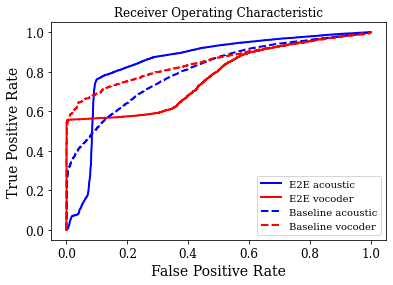

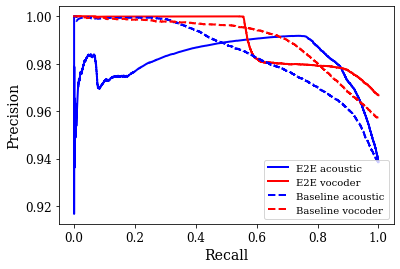

In [54]:
acoustic_e2e={
    'tpr': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/tpr.npy'),
    'fpr': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/fpr.npy'),
    'threshold': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/threshold.npy'),
    'precision': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/precision.npy'),
    'recall': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch26/recall.npy')
}

vocoder_e2e={
    'tpr': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/tpr.npy'),
    'fpr': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/fpr.npy'),
    'threshold': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/threshold.npy'),
    'precision': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/precision.npy'),
    'recall': np.load('docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/recall.npy')
}

baseline_acoustic = {
    'tpr': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/tpr.npy'),
    'fpr': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/fpr.npy'),
    'threshold': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/threshold.npy'),
    'precision': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/precision.npy'),
    'recall': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_acoustic/results/recall.npy')
}

baseline_vocoder = {
    'tpr': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/tpr.npy'),
    'fpr': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/fpr.npy'),
    'threshold': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/threshold.npy'),
    'precision': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/precision.npy'),
    'recall': np.load('/dataa/phucdt/audio-deepfake-source-tracing/exp_vocoder/results/recall.npy')
}
plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# plot ROC curve
plt.figure()
plt.plot(acoustic_e2e['fpr'], acoustic_e2e['tpr'], color='blue', lw=2, label='E2E acoustic')
plt.plot(vocoder_e2e['fpr'], vocoder_e2e['tpr'], color='red', lw=2, label='E2E vocoder')
plt.plot(baseline_acoustic['tpr'], baseline_acoustic['fpr'], color='blue', lw=2, linestyle='--', label='Baseline acoustic')
plt.plot(baseline_vocoder['fpr'], baseline_vocoder['tpr'], color='red', lw=2, linestyle='--', label='Baseline vocoder')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('figs/ROC_curve.pdf', format='pdf', bbox_inches='tight', dpi=400)

plt.show()

# plot AUPR curve
plt.figure()
plt.plot(acoustic_e2e['recall'], acoustic_e2e['precision'], color='blue', lw=2, label='E2E acoustic')
plt.plot(vocoder_e2e['recall'], vocoder_e2e['precision'], color='red', lw=2, label='E2E vocoder')
plt.plot(baseline_acoustic['recall'], baseline_acoustic['precision'], color='blue', lw=2, linestyle='--', label='Baseline acoustic')
plt.plot(baseline_vocoder['recall'], baseline_vocoder['precision'], color='red', lw=2, linestyle='--', label='Baseline vocoder')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.savefig('figs/PR_curve.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

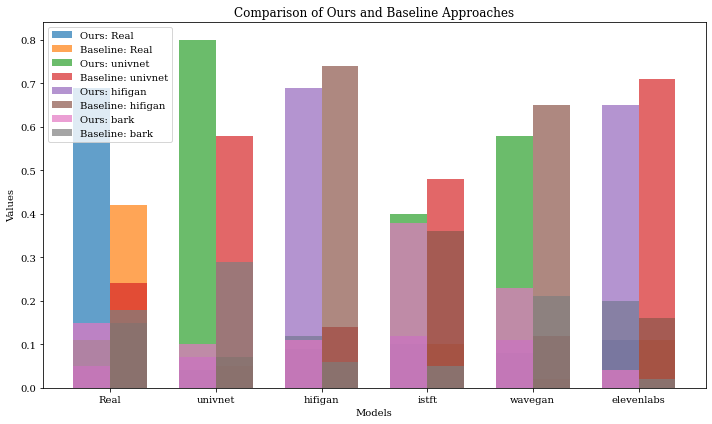

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Data for "Ours" approach
ours = [
    [0.69, 0.11, 0.05, 0.15],
    [0.04, 0.80, 0.07, 0.10],
    [0.09, 0.12, 0.69, 0.11],
    [0.10, 0.40, 0.12, 0.38],
    [0.08, 0.58, 0.11, 0.23],
    [0.11, 0.20, 0.65, 0.04]
]

# Data for "Baseline" approach
baseline = [
    [0.42, 0.24, 0.15, 0.18],
    [0.05, 0.58, 0.07, 0.29],
    [0.06, 0.14, 0.74, 0.06],
    [0.10, 0.48, 0.36, 0.05],
    [0.02, 0.12, 0.65, 0.21],
    [0.11, 0.71, 0.16, 0.02]
]

# Labels
labels = ['Real', 'univnet', 'hifigan', 'istft', 'wavegan', 'elevenlabs']
categories = ['Real', 'univnet', 'hifigan', 'bark']

# Set up the bar positions
x = np.arange(len(labels))
width = 0.35  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
for i, category in enumerate(categories):
    ax.bar(x - width/2, [row[i] for row in ours], width, label=f'Ours: {category}', alpha=0.7)
    ax.bar(x + width/2, [row[i] for row in baseline], width, label=f'Baseline: {category}', alpha=0.7)

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Values')
ax.set_title('Comparison of Ours and Baseline Approaches')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


# DSD-corpus

## preprocess

In [84]:
dsd_df = pd.read_csv('/dataa/phucdt/vocodetect/traindata/ACMCCS/meta_apr3.csv')
dsd_df

,path,Utterence name (file name),TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,group,Speaker name,Gender,Age,label,Model,subset
0,Real/Korean_AIHUB/09MKIS0040/09MKIS0040_12815.wav,09MKIS0040_12815.wav,-,No,Korean,-,-,09MKIS0040_12815,AIHUB,09MKIS0040,Male,Adult,bonafide,-,train
1,Real/Korean_AIHUB/06FKMJ0055/06FKMJ0055_08352.wav,06FKMJ0055_08352.wav,-,No,Korean,-,-,06FKMJ0055_08352,AIHUB,06FKMJ0055,Female,Adult,bonafide,-,train
2,Real/Korean_AIHUB/05MLDS0032/05MLDS0032_07691.wav,05MLDS0032_07691.wav,-,No,Korean,-,-,05MLDS0032_07691,AIHUB,05MLDS0032,Male,Adult,bonafide,-,train
3,Real/Korean_AIHUB/08MKJT0043/08MKJT0043_12087.wav,08MKJT0043_12087.wav,-,No,Korean,-,-,08MKJT0043_12087,AIHUB,08MKJT0043,Male,Adult,bonafide,-,train
4,Real/Korean_AIHUB/05FPYS0052/05FPYS0052_06641.wav,05FPYS0052_06641.wav,-,No,Korean,-,-,05FPYS0052_06641,AIHUB,05FPYS0052,Female,Adult,bonafide,-,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92380,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000079.wav,TTS,No,Korean,-,-,12MWKH0048_000079,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval
92381,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000002.wav,TTS,No,Korean,-,-,12MWKH0048_000002,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval
92382,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000133.wav,TTS,No,Korean,-,-,12MWKH0048_000133,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval
92383,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000026.wav,TTS,No,Korean,-,-,12MWKH0048_000026,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval


In [ ]:
dsd_df['vocoder'] = '-'
dsd_df['acoustic'] = '-'
# dsd_df['group'].unique()
['AIHUB', 'LibriSpeech', 'VCTK', 'Elevenlabs', 'DDDM-VC', 'MeloTTS',
       'VITS-TTS', 'SeamlessM4T-TTS', 'MMSTTS', 'DiffGAN', 'QuickVC',
       'Diff-HierVC', 'Tortoise-TTS', 'StarGANv2-VC', 'OpenVoice',
       'StyleTTS2', 'VITS-AIHUB']

array(['AIHUB', 'LibriSpeech', 'VCTK', 'Elevenlabs', 'DDDM-VC', 'MeloTTS',
       'VITS-TTS', 'SeamlessM4T-TTS', 'MMSTTS', 'DiffGAN', 'QuickVC',
       'Diff-HierVC', 'Tortoise-TTS', 'StarGANv2-VC', 'OpenVoice',
       'StyleTTS2', 'VITS-AIHUB'], dtype=object)

In [88]:
# drop 'SNS2024', 'SNS2023'
dsd_df = dsd_df[~dsd_df['group'].isin(['SNS2024', 'SNS2023'])]

In [92]:
hifigan = ['DDDM-VC', 'DiffGAN','Diff-HierVC','VITS-TTS','VITS-AIHUB','StyleTTS2','OpenVoice','SeamlessM4T-TTS', 'MMSTTS','MeloTTS',]
univnet = ['Tortoise-TTS',]
wavegan = ['StarGANv2-VC',]
istft = ['QuickVC',]
ele = ['Elevenlabs',]

dsd_df['vocoder'] = dsd_df['group'].apply(lambda x: 'hifigan' if x in hifigan else 'univnet' if x in univnet else 'wavegan' if x in wavegan else 'istft' if x in istft else 'ele' if x in ele else 'Real')

/tmp/ipykernel_873051/502415851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsd_df['vocoder'] = dsd_df['group'].apply(lambda x: 'hifigan' if x in hifigan else 'univnet' if x in univnet else 'wavegan' if x in wavegan else 'istft' if x in istft else 'ele' if x in ele else 'Real')


In [91]:
dsd_df['acoustic'] = dsd_df['group']
dsd_df.loc[dsd_df['label']=='bonafide', 'acoustic'] = 'Real'
dsd_df.loc[dsd_df['group']=='VITS-AIHUB', 'acoustic'] = 'vits'
dsd_df.loc[dsd_df['group']=='VITS-TTS', 'acoustic'] = 'vits'
dsd_df.loc[dsd_df['group']=='Tortoise-TTS', 'acoustic'] = 'tortoise'


/tmp/ipykernel_873051/380890727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsd_df['acoustic'] = dsd_df['group']


In [94]:
dsd_df['acoustic'].value_counts()

Real               43800
vits               14695
tortoise            6000
Elevenlabs          5000
QuickVC             3000
StarGANv2-VC        3000
OpenVoice           2600
SeamlessM4T-TTS     2200
DDDM-VC             2000
Diff-HierVC         2000
MMSTTS              1800
StyleTTS2           1300
MeloTTS             1000
DiffGAN              500
Name: acoustic, dtype: int64

In [95]:
dsd_df.to_csv('/dataa/phucdt/vocodetect/traindata/ACMCCS/meta_apr3_ST.csv', index=False)

## eval

In [35]:
dsd_df = pd.read_csv('/dataa/phucdt/vocodetect/traindata/ACMCCS/meta_apr3_ST.csv')
mlaad_df = pd.read_csv('/dataa/phucdt/vocodetect/traindata/mlaad_v5/meta_ST.csv')

In [40]:
dsd_df[dsd_df['subset']=='eval']

,path,Utterence name (file name),TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,group,Speaker name,Gender,Age,label,Model,subset,vocoder,acoustic
3260,Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00301.wav,01FHSH0028_00301.wav,-,No,Korean,-,-,01FHSH0028_00301,AIHUB,01FHSH0028,Female,Adult,bonafide,-,eval,Real,Real
3261,Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00105.wav,01FHSH0028_00105.wav,-,No,Korean,-,-,01FHSH0028_00105,AIHUB,01FHSH0028,Female,Adult,bonafide,-,eval,Real,Real
3262,Real/Korean_AIHUB/01FHSH0028/01FHSH0028_01091.wav,01FHSH0028_01091.wav,-,No,Korean,-,-,01FHSH0028_01091,AIHUB,01FHSH0028,Female,Adult,bonafide,-,eval,Real,Real
3263,Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00049.wav,01FHSH0028_00049.wav,-,No,Korean,-,-,01FHSH0028_00049,AIHUB,01FHSH0028,Female,Adult,bonafide,-,eval,Real,Real
3264,Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00815.wav,01FHSH0028_00815.wav,-,No,Korean,-,-,01FHSH0028_00815,AIHUB,01FHSH0028,Female,Adult,bonafide,-,eval,Real,Real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88890,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000079.wav,TTS,No,Korean,-,-,12MWKH0048_000079,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval,hifigan,vits
88891,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000002.wav,TTS,No,Korean,-,-,12MWKH0048_000002,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval,hifigan,vits
88892,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000133.wav,TTS,No,Korean,-,-,12MWKH0048_000133,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval,hifigan,vits
88893,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000026.wav,TTS,No,Korean,-,-,12MWKH0048_000026,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval,hifigan,vits


In [41]:
mlaad_df.loc[mlaad_df['vocoder']=='-', 'vocoder'] = 'Real'
vocoder_df = mlaad_df.copy()[['path', 'vocoder', 'subset']]
seen_classes = vocoder_df[vocoder_df['subset']=='train']['vocoder'].unique()
seen_classes = np.sort(seen_classes)
vocoder_df
label_map = {seen_classes[i]: i for i in range(len(seen_classes))}
print(label_map)
t = len(label_map)
classes = dsd_df['vocoder'].unique()
for c in classes:
    if c not in label_map:
        label_map[c] = t
        t += 1
print(label_map)
# map_label is reverse of label_map
map_label = {v: k for k, v in label_map.items()}
print(map_label)
vocoder_df = dsd_df.copy()[['path', 'vocoder', 'subset']]
# vocoder_df['label'] = mlaad_df['vocoder'].map(label_map)
# fill NA with -1
# vocoder_df = vocoder_df.fillna(-1)
# label_idx = vocoder_df['label'].unique()
# set the label column type to int
# vocoder_df['label'] = vocoder_df['label'].astype(int)
vocoder_df=vocoder_df[vocoder_df['subset']=='eval']
# vocoder_df = vocoder_df[vocoder_df['label']!=-1]
# map_label = {k: v for k, v in label_map.items() if v in label_idx}
print(vocoder_df)


{'Real': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'unknown': 7}
{'Real': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'unknown': 7, 'ele': 8, 'istft': 9, 'wavegan': 10}
{0: 'Real', 1: 'bark', 2: 'fullband-melgan', 3: 'hifigan', 4: 'melgan', 5: 'multi-melgan', 6: 'univnet', 7: 'unknown', 8: 'ele', 9: 'istft', 10: 'wavegan'}
                                                    path  vocoder subset
3260   Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00301.wav     Real   eval
3261   Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00105.wav     Real   eval
3262   Real/Korean_AIHUB/01FHSH0028/01FHSH0028_01091.wav     Real   eval
3263   Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00049.wav     Real   eval
3264   Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00815.wav     Real   eval
...                                                  ...      ...    ...
88890  Synthesizers/VITS_Korean/12MWKH0048_Voice_data...  

In [47]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/
# display map is the label exist in the dataset
display_map = {0: 'Real', 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6}
pred_df = pd.read_csv("docs/DSD_E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/scores.txt", sep=" ", header=None, usecols=[0, 1, 2])

pred_df.columns = ["path", "pred", "score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)
# print(res_df)
res_df = pd.merge(vocoder_df, pred_df, on='path', how='left')
print(res_df['pred_name'].value_counts())
print(res_df['vocoder'].value_counts())
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['vocoder'].isin(seen_classes)
res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)

# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)


# The OOD EER

# filter only seen classes
res_seen_df = res_df[res_df['vocoder'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['vocoder'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# # visualize confusion matrix
# # display the percenntage of each class in the confusion matrix
# plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# plt.figure(figsize=(10, 10))
# cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())
# disp.plot(cmap='Greens', values_format='.2f')
# # Change label font size
# plt.xlabel('Predicted Label', fontsize=14)
# plt.ylabel('True Label', fontsize=14)
# # Rotate x-axis tick labels
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(fontsize=12)

# # plt.savefig('figs/E2E_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
# plt.show()

for i in dsd_df['vocoder'].unique():
    for j in res_df['pred_name'].unique():
        print(f'{i} - {j}: {res_df[(res_df["vocoder"]==i) & (res_df["pred_name"]==j)].shape[0]}')



Real       27138
hifigan    20677
univnet    13533
bark        9769
Name: pred_name, dtype: int64
Real       35040
hifigan    22477
univnet     4800
ele         4000
istft       2400
wavegan     2400
Name: vocoder, dtype: int64
AUC:  0.7022233855273695
(62317, 8)
ACC:  0.6960700932329862
G-F1:  0.712221470988823
Micro-F1:  0.6960700932329862
Macro-F1:  0.6876485268596694
Confusion matrix:  [[24093  5281  1727  3939]
 [    0     0     0     0]
 [ 2005  2395 15453  2624]
 [  172   458   339  3831]]
{'Real': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'unknown': 7, 'ele': 8, 'istft': 9, 'wavegan': 10}
Real - Real: 24093
Real - univnet: 3939
Real - hifigan: 1727
Real - bark: 5281
ele - Real: 432
ele - univnet: 792
ele - hifigan: 2612
ele - bark: 164
hifigan - Real: 2005
hifigan - univnet: 2624
hifigan - hifigan: 15453
hifigan - bark: 2395
istft - Real: 245
istft - univnet: 956
istft - hifigan: 288
istft - bark: 911
univnet - Real: 172
uni

In [49]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/
# display map is the label exist in the dataset
display_map = {'Real': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6}
pred_df = pd.read_csv("/dataa/phucdt/audio-deepfake-source-tracing/exp_dsd/results/scores_eval.txt", sep=" ", header=None, usecols=[0, 1, 2, 3])

pred_df.columns = ["label", "path", "pred", "pred_score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)
pred_df['vocoder'] = pred_df['label'].map(map_label)

# print(pred_df)
# print(res_df)
# res_df = pd.merge(vocoder_df, pred_df, on='path', how='left')
res_df = pred_df.copy()
print(res_df['pred_name'].value_counts())
print(res_df['vocoder'].value_counts())
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['vocoder'].isin(seen_classes)

# calculate the AUC of the pred_score
# from sklearn.metrics import roc_auc_score
# auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
# print("AUC: ", auc)


# The OOD EER

# filter only seen classes
res_seen_df = res_df[res_df['vocoder'].isin(seen_classes)]
print(res_seen_df.shape)
print(res_seen_df['vocoder'].value_counts())
# calculate ACC, F1-score
y_true = res_seen_df['vocoder'].values
y_pred = res_seen_df['pred_name'].values
# acc = accuracy_score(y_true, y_pred)
# cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
# print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
# print("Confusion matrix: ", cm)
print(label_map)
# # visualize confusion matrix
# # display the percenntage of each class in the confusion matrix
# plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# plt.figure(figsize=(10, 10))
# cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())
# disp.plot(cmap='Greens', values_format='.2f')
# # Change label font size
# plt.xlabel('Predicted Label', fontsize=14)
# plt.ylabel('True Label', fontsize=14)
# # Rotate x-axis tick labels
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(fontsize=12)

# # plt.savefig('figs/E2E_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
# plt.show()

for i in dsd_df['vocoder'].unique():
    for j in res_df['pred_name'].unique():
        print(f'{i} - {j}: {res_df[(res_df["label"]==i) & (res_df["pred_name"]==j)].shape[0]}')



hifigan            25329
univnet            18731
Real               17189
bark                9775
fullband-melgan       82
multi-melgan          11
Name: pred_name, dtype: int64
Real               35040
fullband-melgan    22477
melgan              4800
bark                4000
hifigan             2400
multi-melgan        2400
Name: vocoder, dtype: int64
(71117, 7)
Real               35040
fullband-melgan    22477
melgan              4800
bark                4000
hifigan             2400
multi-melgan        2400
Name: vocoder, dtype: int64


G-F1:  0.2918366724142284
Micro-F1:  0.2228721683985545
Macro-F1:  0.1083669214268808
{'Real': 0, 'bark': 1, 'fullband-melgan': 2, 'hifigan': 3, 'melgan': 4, 'multi-melgan': 5, 'univnet': 6, 'unknown': 7, 'ele': 8, 'istft': 9, 'wavegan': 10}
Real - Real: 0
Real - hifigan: 0
Real - univnet: 0
Real - bark: 0
Real - multi-melgan: 0
Real - fullband-melgan: 0
ele - Real: 0
ele - hifigan: 0
ele - univnet: 0
ele - bark: 0
ele - multi-melgan: 0
ele - fullband-melgan: 0
hifigan - Real: 0
hifigan - hifigan: 0
hifigan - univnet: 0
hifigan - bark: 0
hifigan - multi-melgan: 0
hifigan - fullband-melgan: 0
istft - Real: 0
istft - hifigan: 0
istft - univnet: 0
istft - bark: 0
istft - multi-melgan: 0
istft - fullband-melgan: 0
univnet - Real: 0
univnet - hifigan: 0
univnet - univnet: 0
univnet - bark: 0
univnet - multi-melgan: 0
univnet - fullband-melgan: 0
wavegan - Real: 0
wavegan - hifigan: 0
wavegan - univnet: 0
wavegan - bark: 0
wavegan - multi-melgan: 0
wavegan - fullband-melgan: 0


In [215]:
dsd_df[dsd_df['subset']=='eval']['vocoder'].value_counts()

Real       35040
hifigan    22477
univnet     4800
ele         4000
istft       2400
wavegan     2400
Name: vocoder, dtype: int64

In [83]:
# mlaad_df = mlaad_df[mlaad_df['acoustic']!='unknown']
acoustic_df = dsd_df.copy()[['path', 'acoustic', 'subset']]

seen_classes = mlaad_df[mlaad_df['subset']=='train']['acoustic'].unique()
acoustic_df.loc[acoustic_df['acoustic']=='-', 'acoustic'] = 'Real'
seen_classes = np.sort(seen_classes)
seen_classes[0] = 'Real'
label_map = {seen_classes[i]: i for i in range(len(seen_classes))}
print(label_map)
t = len(label_map)
classes = dsd_df['acoustic'].unique()
for c in classes:
    if c not in label_map:
        label_map[c] = t
        t += 1

# change key of '-' to 'Real'

print(label_map)
# map_label is reverse of label_map
map_label = {v: k for k, v in label_map.items()}
print(map_label)

# fill NA with -1
# vocoder_df = vocoder_df.fillna(-1)
# label_idx = vocoder_df['label'].unique()
# set the label column type to int
# vocoder_df['label'] = vocoder_df['label'].astype(int)
acoustic_df=acoustic_df[acoustic_df['subset']=='eval']
# vocoder_df = vocoder_df[vocoder_df['label']!=-1]
# map_label = {k: v for k, v in label_map.items() if v in label_idx}
print(acoustic_df)



{'Real': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 'tacotron2': 6, 'vits': 7, 'xtts_v1.1': 8, 'xtts_v2': 9}
{'Real': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 'tacotron2': 6, 'vits': 7, 'xtts_v1.1': 8, 'xtts_v2': 9, 'Elevenlabs': 10, 'DDDM-VC': 11, 'MeloTTS': 12, 'SeamlessM4T-TTS': 13, 'MMSTTS': 14, 'DiffGAN': 15, 'QuickVC': 16, 'Diff-HierVC': 17, 'tortoise': 18, 'StarGANv2-VC': 19, 'OpenVoice': 20, 'StyleTTS2': 21}
{0: 'Real', 1: 'Mars5', 2: 'Metavoice', 3: 'bark', 4: 'fast_pitch', 5: 'speedy-speech', 6: 'tacotron2', 7: 'vits', 8: 'xtts_v1.1', 9: 'xtts_v2', 10: 'Elevenlabs', 11: 'DDDM-VC', 12: 'MeloTTS', 13: 'SeamlessM4T-TTS', 14: 'MMSTTS', 15: 'DiffGAN', 16: 'QuickVC', 17: 'Diff-HierVC', 18: 'tortoise', 19: 'StarGANv2-VC', 20: 'OpenVoice', 21: 'StyleTTS2'}
                                                    path acoustic subset
3260   Real/Korean_AIHUB/01FHSH0028/01FHSH0028_00301.wav     Real   eval
3261   Real

In [84]:
# docs/E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_vocoder_epoch14/
# display map is the label exist in the dataset
# display_map = {'Real': 0, 'bark': 1, 'fast_pitch': 2, 'speedy-speech': 3, 'tacotron2': 4, 'vits': 5, 'xtts_v1.1': 6, 'xtts_v2': 7}
pred_df = pd.read_csv("docs/DSD_E2E_Fair_augall_wav2vec_vib_sclnormal_1.0CE_mlaad_acoustic_epoch9/scores.txt", sep=" ", header=None, usecols=[0, 1, 2])

pred_df.columns = ["path", "pred", "score"]
pred_df['pred_name'] = pred_df['pred'].map(map_label)
# print(res_df)
# print(pred_df)
res_df = pd.merge(acoustic_df, pred_df, on='path', how='inner')
# print(res_df['pred_name'].value_counts())
# print(res_df['acoustic'].value_counts())
# for OOD
res_df['seen'] = False
res_df['seen'] = res_df['acoustic'].isin(seen_classes)
# print(res_df['score'])
res_df['score'] = res_df['score'].apply(lambda x: x.replace(' ','').replace('[', '').replace(']', '').split(','))
res_df['score'] = res_df['score'].apply(lambda x: [float(i) for i in x])
res_df['pred_score'] = res_df.apply(lambda x: x['score'][x['pred']], axis=1)

# calculate the AUC of the pred_score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(res_df['seen'], res_df['pred_score'])
print("AUC: ", auc)


# The OOD EER

# filter only seen classes
res_seen_df = res_df[res_df['acoustic'].isin(seen_classes)]
print(res_seen_df.shape)
# calculate ACC, F1-score
y_true = res_seen_df['acoustic'].values
y_pred = res_seen_df['pred_name'].values
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
g_f1 = G_f1_score(label_map, y_true, y_pred)
micro_f1 = micro_f1_score(label_map, y_true, y_pred)
macro_f1 = macro_f1_score(label_map, y_true, y_pred)
print("ACC: ", acc)
print("G-F1: ", g_f1)
print("Micro-F1: ", micro_f1)
print("Macro-F1: ", macro_f1)
print("Confusion matrix: ", cm)
print(label_map)
# # visualize confusion matrix
# # display the percenntage of each class in the confusion matrix
# plt.rcParams.update({'font.family': 'serif', 'font.size': 10})

# plt.figure(figsize=(10, 10))
# cm_percentage = cm.astype('float', ) / cm.sum(axis=1)[:, np.newaxis]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=display_map.values())
# disp.plot(cmap='Greens', values_format='.2f')
# # Change label font size
# plt.xlabel('Predicted Label', fontsize=14)
# plt.ylabel('True Label', fontsize=14)
# # Rotate x-axis tick labels
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(fontsize=12)

# # plt.savefig('figs/E2E_vocoder_ID_cm.pdf', format='pdf', bbox_inches='tight', dpi=400)
# plt.show()

for i in dsd_df['acoustic'].unique():
    for j in res_df['pred_name'].unique():
        print(f'{i} - {j}: {res_df[(res_df["acoustic"]==i) & (res_df["pred_name"]==j)].shape[0]}')



AUC:  0.6788309255372871
(46797, 8)
ACC:  0.5662542470671197
G-F1:  0.4145975123210514
Micro-F1:  0.5662542470671197
Macro-F1:  0.4145975123210514
Confusion matrix:  [[    0     0     0     0     0     0     0     0]
 [ 1276 26499  5542    37     0     0  1073   613]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [  991  2376   617    89     4     0  1860  5820]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]]
{'Real': 0, 'Mars5': 1, 'Metavoice': 2, 'bark': 3, 'fast_pitch': 4, 'speedy-speech': 5, 'tacotron2': 6, 'vits': 7, 'xtts_v1.1': 8, 'xtts_v2': 9, 'Elevenlabs': 10, 'DDDM-VC': 11, 'MeloTTS': 12, 'SeamlessM4T-TTS': 13, 'MMSTTS': 14, 'DiffGAN': 15, 'QuickVC': 16, 'Diff-HierVC': 17, 'tortoise': 18, 'StarGANv2-VC': 19, 'OpenVoice': 20, 'StyleTTS2': 21}
Real - Real: 26499
Real - xtts_v2: 613
Real - xtts_v1.1: 1073
Real - bark: 5